In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras import backend as K

In [2]:
# COMP3710 Project
# Question 4: Segment the ISICs data set with the Improved UNet [1] with all labels having a minimum Dice similarity
# coefficient of 0.8 on the test set. [Normal Difficulty]

# Student Name: Xiao Sun
# Studeng Number: 45642586


In [5]:


img_GroundTruth = os.listdir(r'C:\Users\s4564258\Downloads\ISIC2018_Task1_Training_GroundTruth_x2')
img_input = os.listdir(r'C:\Users\s4564258\Downloads\ISIC2018_Task1-2_Training_Input_x2')

len(img_GroundTruth), len(img_input)


(2596, 2596)

In [6]:
img_GroundTruth[0], img_GroundTruth[-1]

('ATTRIBUTION.txt', 'LICENSE.txt')

In [43]:


def load_data():
    
    
    # we use img_input[1:-1] because the first and last file is not image document.
    #load input images and process into tf dataset.
    img_input = os.listdir(r'C:\Users\s4564258\Downloads\ISIC2018_Task1-2_Training_Input_x2')
    img_input = [os.path.join(r'C:\Users\s4564258\Downloads\ISIC2018_Task1-2_Training_Input_x2', path) for path in img_input[1:-1]]
    path_img_input = tf.data.Dataset.from_tensor_slices(img_input)
    image_input_ds = path_img_input.map(data_processing_norm_input, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    
    #load mask images and process into tf dataset.
    img_GroundTruth = os.listdir(r'C:\Users\s4564258\Downloads\ISIC2018_Task1_Training_GroundTruth_x2')
    img_GroundTruth = [os.path.join(r'C:\Users\s4564258\Downloads\ISIC2018_Task1_Training_GroundTruth_x2', path) for path in img_GroundTruth[1:-1]]
    path_img_GroundTruth = tf.data.Dataset.from_tensor_slices(img_GroundTruth)
    image_mask_ds = path_img_GroundTruth.map(data_processing_norm_GT, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    
    image_ds = tf.data.Dataset.zip((image_input_ds, image_mask_ds))
    
    # implot_show(image_input_ds.take(4))
    implot_show(image_ds.take(4))
    
    return image_ds
    
def data_processing_norm_input(image):
    # process input img data into tf tensor, and normalization.
    
    img_raw = tf.io.read_file(image)
    image = tf.image.decode_jpeg(img_raw, channels=3)
    image = tf.image.resize(image, [256, 256])
    image /= 255.0  # normalize to [0,1] range
    
    return image
    
    
def data_processing_norm_GT(image):
    # process mask (GroundTruth) img data into tf tensor, and normalization.
    
    img_raw = tf.io.read_file(image)
    image = tf.image.decode_jpeg(img_raw, channels=1)
    image = tf.image.resize(image, [256, 256])
    image /= 255.0  # normalize to [0,1] range
    
    return image
    
def implot_show(ds):
    # using imshow to vertify correctly load and process data
    
    for input_img, mask_img in ds:
        
        print(input_img.shape)
        display_list = [input_img, mask_img]
        plt.figure(figsize=(18, 18))
        for i in range(2):
            print(display_list[i].shape)
            plt.subplot(1, 2, i+1)
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
            plt.axis('off')
            plt.show()
        

In [44]:
def split_train_test_val(image_ds):
    # split the whole tf data set into train, validation and test.
    
    # this step will slow down the process.
    # size = len(list(image_ds))
    size = 2594
    
    train_size = int(0.7 * size)
    val_size = int(0.15 * size)
    test_size = int(0.15 * size)
    
    train_image = image_ds.take(train_size)
    val_image = image_ds.skip(train_size)
    test_image = val_image.take(test_size)
    val_image = val_image.skip(test_size)
    
    return train_image, val_image, test_image

(256, 256, 3)
(256, 256, 3)


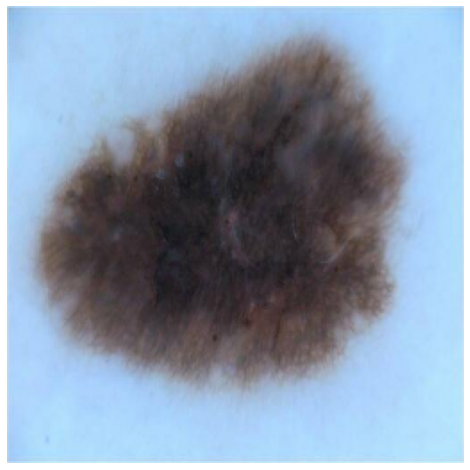

(256, 256, 1)


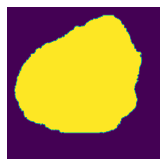

(256, 256, 3)
(256, 256, 3)


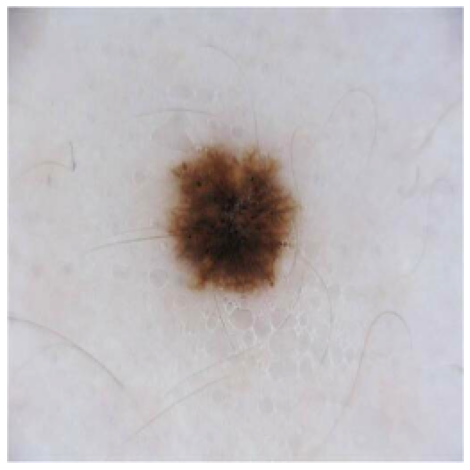

(256, 256, 1)


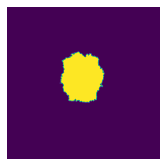

(256, 256, 3)
(256, 256, 3)


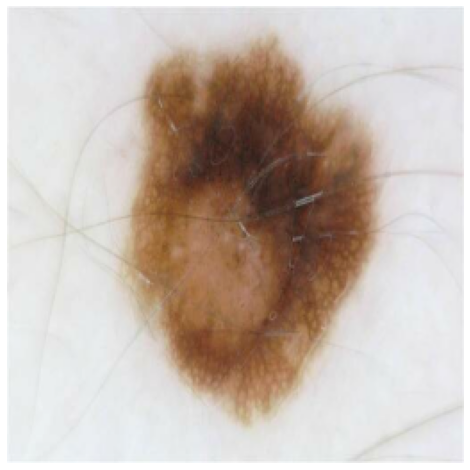

(256, 256, 1)


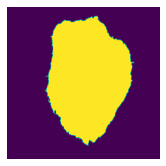

(256, 256, 3)
(256, 256, 3)


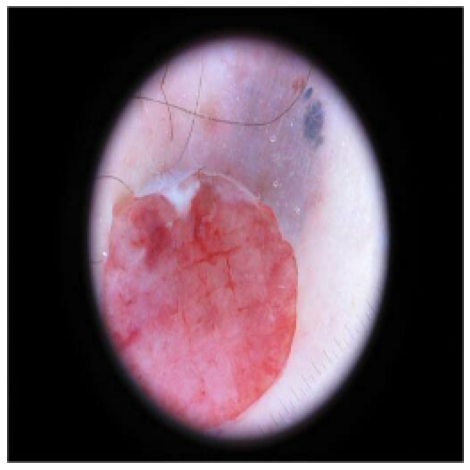

(256, 256, 1)


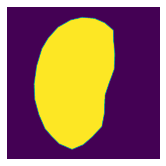

In [46]:
image_ds = load_data()

image_train, image_val, image_test = split_train_test_val(image_ds)
#mask_train, mask_val, mask_test = split_train_test_val(image_mask_ds)


BATCH_SIZE=32
STEPS_PER_EPOCH =1815//BATCH_SIZE
image_train = image_train.batch(BATCH_SIZE).repeat()
image_val = image_val.batch(BATCH_SIZE)
image_test = image_test.batch(BATCH_SIZE)


In [123]:
len(list(image_val))

7

In [10]:
# leaky ReLU, no batchnormalization


def UNet_context_module(filters, inp, layer_name):
    # Each context_module consists of two 3x3 conv layers and a dropout(0.3) in between.
    
    x1 = layers.Conv2D(filters, kernel_size =3, padding = 'same')(inp)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.LeakyReLU(alpha=0.01)(x1)
    x1 = layers.Dropout(.3)(x1)
    x2 = layers.Conv2D(filters, kernel_size =3, padding = 'same')(x1)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.LeakyReLU(alpha=0.01)(x2)

    return x2
    
def UNet_upsampling_module(filters, inp):
    # ...It is like a layer that combines the UpSampling2D and Conv2D layers into one layer. 
    
    # what twice means in paper (Answer from Piazza: kernel size 2 by 2)?
    x1 = layers.UpSampling2D(size=(2,2))(inp)
    x2 = layers.Conv2D(filters, kernel_size =3, padding = 'same')(x1)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.LeakyReLU(alpha=0.01)(x2)
    
    return x2
    
    
def UNet_localization_module(filters, inp):
    # A localization module consists of a 3x3x3 convolution followed by a 1x1x1 convolution that halves the
    # number of feature maps.
    
    x1 = layers.Conv2D(filters, kernel_size =3, padding = 'same')(inp)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.LeakyReLU(alpha=0.01)(x1)
    
    x1 = layers.Dropout(.3)(x1)
    x2 = layers.Conv2D(filters, kernel_size =1, padding = 'same')(x1)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.LeakyReLU(alpha=0.01)(x2)
    
    return x2
    
    

In [49]:
def Improved_UNet_model():
    
    filters = 16
    input_layer = Input((256,256,3))
    
    # block 1:
    block1_x1 = layers.Conv2D(filters, kernel_size =3, padding = 'same')(input_layer)
    #block1_x1 = layers.BatchNormalization()(block1_x1)
    block1_x1 = layers.LeakyReLU(alpha=0.01)(block1_x1)
    #block1_x1 = layers.Dropout(0.3)(block1_x1)
    
    block1_x2 = UNet_context_module(filters, block1_x1, "context_module1")
    
    output_b1 = layers.Add()([block1_x1, block1_x2])
    
    
    # block 2:
    block2_x1 = layers.Conv2D(filters*2, kernel_size =3, strides = 2, padding = 'same')(output_b1)
    #block2_x1 = layers.BatchNormalization()(block2_x1)
    block2_x1 = layers.LeakyReLU(alpha=0.01)(block2_x1)
    #block2_x1 = layers.Dropout(0.3)(block2_x1)
    
    block2_x2 = UNet_context_module(filters*2, block2_x1, "context_module2")
    
    output_b2 = layers.Add()([block2_x1, block2_x2])
    
    
    # block 3:
    block3_x1 = layers.Conv2D(filters*4, kernel_size =3, strides = 2, padding = 'same')(output_b2)
    #block3_x1 = layers.BatchNormalization()(block3_x1)
    block3_x1 = layers.LeakyReLU(alpha=0.01)(block3_x1)
    #block3_x1 = layers.Dropout(0.3)(block3_x1)
    
    block3_x2 = UNet_context_module(filters*4, block3_x1, "context_module3")
    
    output_b3 = layers.Add()([block3_x1, block3_x2])
    
    
    # block 4:
    block4_x1 = layers.Conv2D(filters*8, kernel_size =3, strides = 2, padding = 'same')(output_b3)
    #block4_x1 = layers.BatchNormalization()(block4_x1)
    block4_x1 = layers.LeakyReLU(alpha=0.01)(block4_x1)
    #block4_x1 = layers.Dropout(0.3)(block4_x1)
    
    block4_x2 = UNet_context_module(filters*8, block4_x1, "context_module4")
    
    output_b4 = layers.Add()([block4_x1, block4_x2])
    
    
    # block 5:
    block5_x1 = layers.Conv2D(filters*16, kernel_size =3, strides = 2, padding = 'same')(output_b4)
    #block5_x1 = layers.BatchNormalization()(block5_x1)
    block5_x1 = layers.LeakyReLU(alpha=0.01)(block5_x1)
    #block5_x1 = layers.Dropout(0.3)(block5_x1)
    
    block5_x2 = UNet_context_module(filters*16, block5_x1, "context_module5")
    
    output_b5 = layers.Add()([block5_x1, block5_x2])
    
    
    # up_block 6:
    block6_x1 = UNet_upsampling_module(filters*8, output_b5)
    # connection
    output_b6 = layers.concatenate([output_b4, block6_x1])
    
    
    # up_block 7:
    block7_x1 = UNet_localization_module(filters*8, output_b6)
    block7_x2 = UNet_upsampling_module(filters*4, block7_x1)
    # connection
    output_b7 = layers.concatenate([output_b3, block7_x2])
    
    
    # up_block 8:
    block8_x1 = UNet_localization_module(filters*4, output_b7)
    block8_x2 = UNet_upsampling_module(filters*2, block8_x1)
    # connection
    output_b8 = layers.concatenate([output_b2, block8_x2])
    
    
    # up_block 9:
    block9_x1 = UNet_localization_module(filters*2, output_b8)
    block9_x2 = UNet_upsampling_module(filters, block9_x1)
    # connection
    output_b9 = layers.concatenate([output_b1, block9_x2])
    
    # upscale
    segmentation_1 = layers.Conv2D(1, kernel_size =3, padding = 'same')(block7_x1)
    segmentation_1 = layers.UpSampling2D(size=(8,8))(segmentation_1)
    segmentation_2 = layers.Conv2D(1, kernel_size =3, padding = 'same')(block8_x1)
    segmentation_2 = layers.UpSampling2D(size=(4,4))(segmentation_2)
    final_block_output = layers.Conv2D(1, kernel_size =3, padding = 'same')(output_b9)
    
    output = layers.Add()([segmentation_1, segmentation_2, final_block_output])
    #output = layers.BatchNormalization()(output)
    output = layers.Activation('sigmoid')(output)
    
    improved_unet_model = Model(input_layer, output, name="improved_unet_model")
    improved_unet_model.summary()
    
    return improved_unet_model
    

In [50]:
improved_unet_model = Improved_UNet_model()

Model: "improved_unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_112 (Conv2D)             (None, 256, 256, 16) 448         input_5[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_100 (LeakyReLU)     (None, 256, 256, 16) 0           conv2d_112[0][0]                 
__________________________________________________________________________________________________
conv2d_113 (Conv2D)             (None, 256, 256, 16) 2320        leaky_re_lu_100[0][0]            
________________________________________________________________________________

In [13]:
# Dice coef

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [51]:
from tensorflow.keras.optimizers import SGD
opt = SGD(lr=0.2)

# learning rate decay
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.985,
    staircase=True)
# opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
opt = SGD(learning_rate=lr_schedule)


improved_unet_model.compile(optimizer=opt, loss=dice_coef_loss, metrics=[dice_coef])

VALIDATION_STEPS = 390//BATCH_SIZE

model_history = improved_unet_model.fit(image_train,steps_per_epoch=STEPS_PER_EPOCH ,epochs=30, validation_data=image_val)

Train for 56 steps, validate for 13 steps
Epoch 1/30
56/56 [==============================] - 36s 641ms/step - loss: 0.3851 - dice_coef: 0.6149 - val_loss: 0.8738 - val_dice_coef: 0.1262
Epoch 2/30
56/56 [==============================] - 34s 611ms/step - loss: 0.3177 - dice_coef: 0.6823 - val_loss: 0.8715 - val_dice_coef: 0.1285
Epoch 3/30
56/56 [==============================] - 33s 583ms/step - loss: 0.2871 - dice_coef: 0.7129 - val_loss: 0.4220 - val_dice_coef: 0.5780
Epoch 4/30
56/56 [==============================] - 33s 584ms/step - loss: 0.2673 - dice_coef: 0.7327 - val_loss: 0.4157 - val_dice_coef: 0.5843
Epoch 5/30
56/56 [==============================] - 34s 601ms/step - loss: 0.2579 - dice_coef: 0.7421 - val_loss: 0.4351 - val_dice_coef: 0.5649
Epoch 6/30
56/56 [==============================] - 32s 567ms/step - loss: 0.2508 - dice_coef: 0.7492 - val_loss: 0.3207 - val_dice_coef: 0.6793
Epoch 7/30
56/56 [==============================] - 32s 572ms/step - loss: 0.2380 - dice

In [ ]:
# not run
# learning rate decay for adam
initial_learning_rate = 0.005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.985,
    staircase=True)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


improved_unet_model_2.compile(optimizer=opt, loss=dice_coef_loss, metrics=[dice_coef])

VALIDATION_STEPS = 390//BATCH_SIZE

model_history = improved_unet_model_2.fit(image_train,steps_per_epoch=STEPS_PER_EPOCH ,epochs=100, validation_data=image_val)

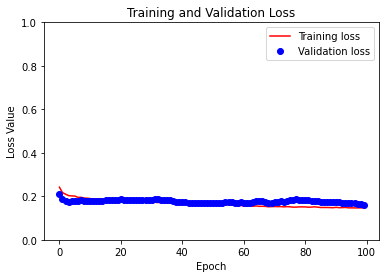

In [113]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(100)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

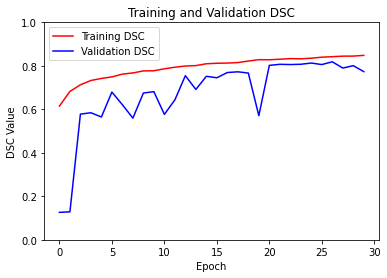

In [52]:
def plot_DSC():
    dsc = model_history.history['dice_coef']
    val_dsc = model_history.history['val_dice_coef']

    epochs = range(30)

    plt.figure()
    plt.plot(epochs, dsc, 'r', label='Training DSC')
    plt.plot(epochs, val_dsc, 'b', label='Validation DSC')
    plt.title('Training and Validation DSC')
    plt.xlabel('Epoch')
    plt.ylabel('DSC Value')
    plt.ylim([0, 1])
    plt.legend()
    plt.show()
plot_DSC()

In [53]:
improved_unet_model.evaluate(image_test)

13/13 [==============================] - 9s 717ms/step - loss: 0.2912 - dice_coef: 0.7088


[0.29122360394551206, 0.70877635]

In [44]:
image_input_ds, image_mask_ds
len(list(image_input_ds))

2594

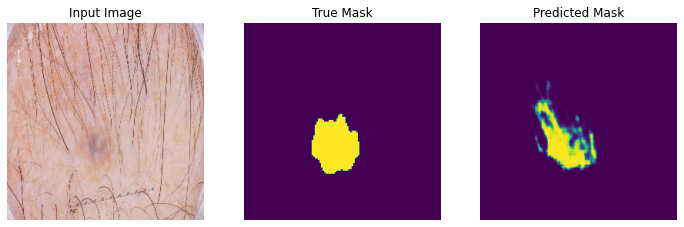

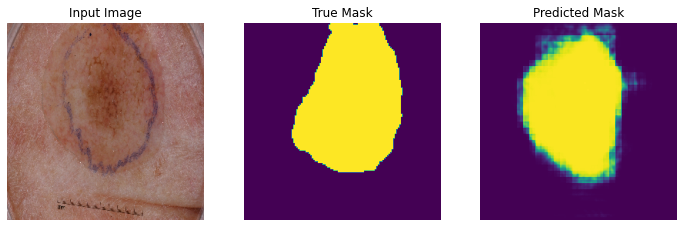

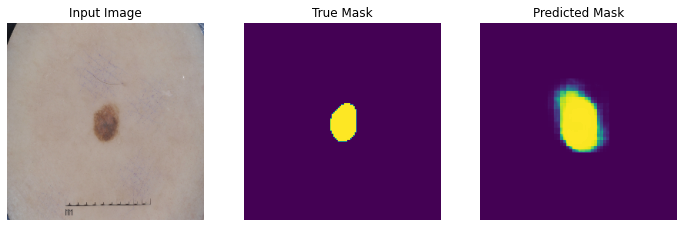

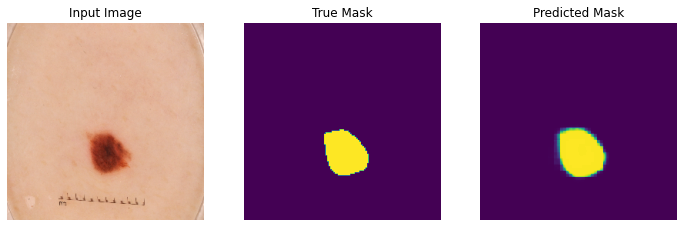

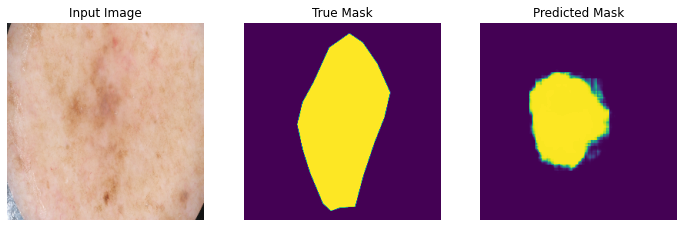

In [55]:

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def implot_show_predict(ds):
    # using imshow to vertify correctly load and process data
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for input_img, mask_img in ds:
        
        input_img_pred = tf.expand_dims(input_img, axis=0)
        pred_mask = improved_unet_model.predict(input_img_pred)
        display_list = [input_img, mask_img, pred_mask[0]]
        
        plt.figure(figsize=(12, 12))
        for i in range(len(display_list)):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
            plt.axis('off')
        plt.show()

image_train, image_val, image_test = split_train_test_val(image_ds)
implot_show_predict(image_test.take(5))

In [ ]:
first i used relu, however the result is noot very good.
Then i follow the instruction in paper, using leaky relu. 

sigmoid and softmax

Then try using optimizer = 'adam', sgd with different learning rate
sgd: training--0.81; val--0.7; test--0.69;
    
then add batch normalization
after 50 epoch
training--0.85; val--0.79; test--0.75;

In last element wise add, use average to instead (not used)

# why use sgd instead of adam, try adam and know difference

because overfitting, i add dropout layer